In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Locations for the training, validation and test sets

train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [5]:
# Define the image data generator
def get_ImageDataGenerator():

    image_gen = ImageDataGenerator(rescale=1/255.)

    return image_gen
    

In [6]:
# Get an ImageDataGenerator

image_gen = get_ImageDataGenerator()

In [123]:
# Create a data generator to read files from directory
def get_generator(image_data_generator, directory, seed=None):
    
    img_gen = image_data_generator.flow_from_directory(directory,target_size=(64,64),
                                                       classes=['classroom','conference_room','church_outdoor'],
                                                       class_mode="categorical", batch_size=20,seed=seed)

    return img_gen
    

In [8]:
# Create the train and validation data generators
train_generator = get_generator(image_gen, train_dir)
valid_generator = get_generator(image_gen, valid_dir)

Found 300 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


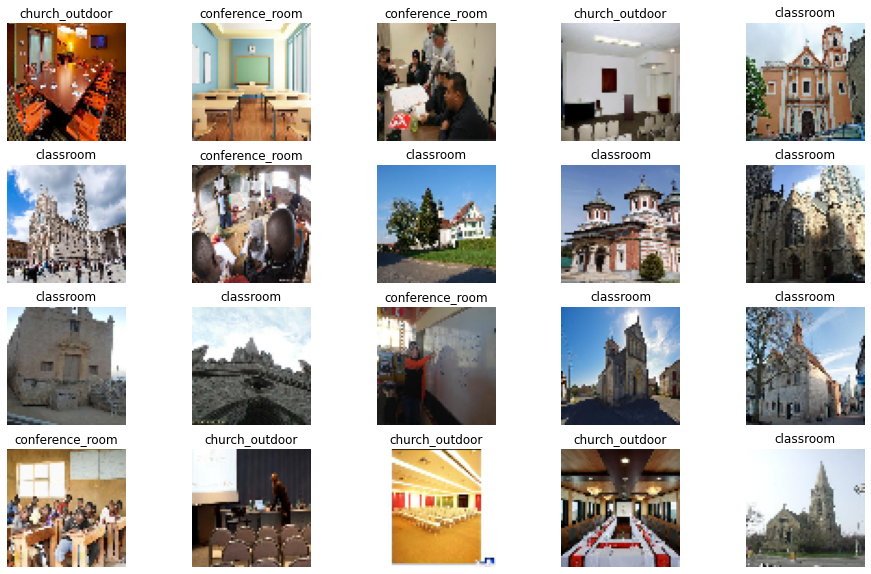

In [9]:
# Display a few images and labels from the training set

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
lsun_classes = ['classroom', 'conference_room', 'church_outdoor']

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [10]:
# Reset the training generator

train_generator = get_generator(image_gen, train_dir)

Found 300 images belonging to 3 classes.


In [18]:
# Define a CNN model
def get_model(input_shape):
    

    input = tf.keras.Input(shape=input_shape)
    h = Conv2D(8, (8,8), activation="relu", padding="same")(input)
    h = MaxPool2D((2,2))(h)
    h = Conv2D(4, (4,4), activation="relu", padding="same")(h)
    h = MaxPool2D((2,2))(h)
    h = Flatten()(h)
    h = Dense(16, activation="relu")(h)
    output = Dense(3, activation="softmax")(h)

    model = tf.keras.Model(inputs=input, outputs=output)

    opt = Adam(0.0005)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model
    

In [19]:
# Build and compile the model

lsun_model = get_model((64, 64, 3))
lsun_model.summary()  # Print the model summary

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1544      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 4)         516       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1640

In [20]:
# Train the model
def train_model(model, train_gen, valid_gen, epochs):
    
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001)
    callbacks = [earlystopping, reduce_lr]

    history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks)

    return history
    

In [21]:
# Train the model for (maximum) 50 epochs

history = train_model(lsun_model, train_generator, valid_generator, epochs=50)

Epoch 1/50
15/15 [==============================] - 2s 97ms/step - loss: 1.1274 - accuracy: 0.2778 - val_loss: 1.0987 - val_accuracy: 0.3250
Epoch 2/50
15/15 [==============================] - 1s 79ms/step - loss: 1.0857 - accuracy: 0.4207 - val_loss: 1.0890 - val_accuracy: 0.3417
Epoch 3/50
15/15 [==============================] - 1s 77ms/step - loss: 1.0609 - accuracy: 0.4522 - val_loss: 1.0557 - val_accuracy: 0.4917
Epoch 4/50
15/15 [==============================] - 1s 77ms/step - loss: 1.0293 - accuracy: 0.5489 - val_loss: 1.0068 - val_accuracy: 0.4667
Epoch 5/50
15/15 [==============================] - 1s 77ms/step - loss: 0.9794 - accuracy: 0.5053 - val_loss: 0.9358 - val_accuracy: 0.5333
Epoch 6/50
15/15 [==============================] - 1s 79ms/step - loss: 0.8806 - accuracy: 0.5846 - val_loss: 0.9059 - val_accuracy: 0.5333
Epoch 7/50
15/15 [==============================] - 1s 77ms/step - loss: 0.7485 - accuracy: 0.6365 - val_loss: 0.8109 - val_accuracy: 0.6833
Epoch 8/50
15

#### Plot the learning curves

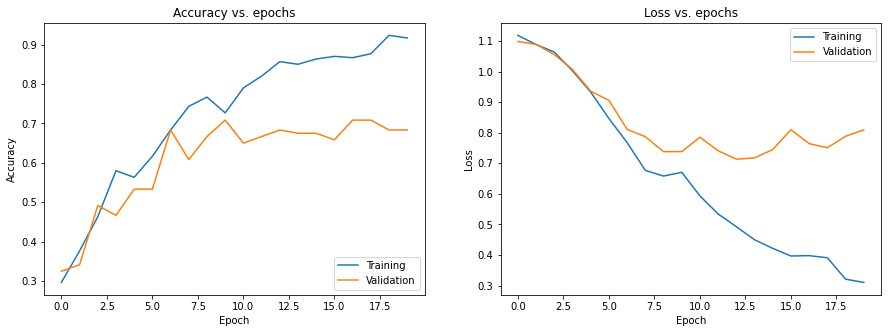

In [22]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    try:
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
    except KeyError:
      plt.plot(history.history['categorical_accuracy'])
      plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

From the above plots, we can see that the model is overfitting. Let us apply a few data augmentation techniques to help reduce overfitting.

In [28]:
# Create variations of the data
def get_ImageDataGenerator_augmented():

    img_gen = ImageDataGenerator(rescale=1/255, rotation_range=30, brightness_range=(0.5, 1.5), 
                                 horizontal_flip=True)
    
    return img_gen
    

In [29]:
# Get an ImageDataGenerator
image_gen_aug = get_ImageDataGenerator_augmented()

In [30]:
# Define training and validation generators 
valid_generator_aug = get_generator(image_gen_aug, valid_dir)
train_generator_aug = get_generator(image_gen_aug, train_dir, seed=10)

Found 120 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [31]:
# Reset the original train_generator with the same random seed
train_generator = get_generator(image_gen, train_dir, seed=10)

Found 300 images belonging to 3 classes.


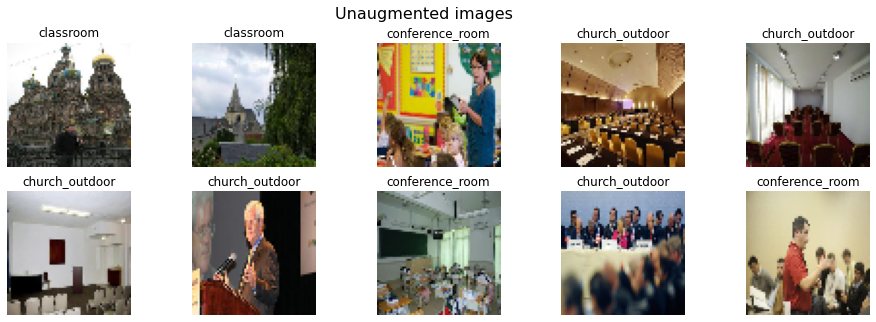

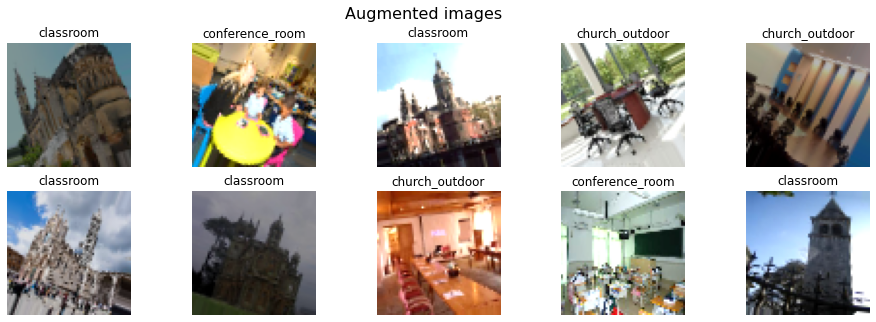

In [32]:
# Display a few images and labels from the non-augmented and augmented generators

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(lsun_classes[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [33]:
# Reset the augmented data generator
train_generator_aug = get_generator(image_gen_aug, train_dir)

Found 300 images belonging to 3 classes.


In [34]:
# Build and compile a new model
lsun_new_model = get_model((64, 64, 3))

In [35]:
# Train the model
history_augmented = train_model(lsun_new_model, train_generator_aug, valid_generator_aug, epochs=50)

Epoch 1/50
15/15 [==============================] - 2s 128ms/step - loss: 1.0958 - accuracy: 0.3655 - val_loss: 1.0924 - val_accuracy: 0.3667
Epoch 2/50
15/15 [==============================] - 2s 112ms/step - loss: 1.1000 - accuracy: 0.3486 - val_loss: 1.0770 - val_accuracy: 0.3583
Epoch 3/50
15/15 [==============================] - 2s 113ms/step - loss: 1.0829 - accuracy: 0.3747 - val_loss: 1.0728 - val_accuracy: 0.4000
Epoch 4/50
15/15 [==============================] - 2s 114ms/step - loss: 1.0595 - accuracy: 0.4519 - val_loss: 1.0424 - val_accuracy: 0.4833
Epoch 5/50
15/15 [==============================] - 2s 122ms/step - loss: 1.0348 - accuracy: 0.5149 - val_loss: 1.0289 - val_accuracy: 0.3750
Epoch 6/50
15/15 [==============================] - 2s 118ms/step - loss: 0.9375 - accuracy: 0.5927 - val_loss: 0.9751 - val_accuracy: 0.5833
Epoch 7/50
15/15 [==============================] - 2s 116ms/step - loss: 0.9255 - accuracy: 0.6046 - val_loss: 0.9176 - val_accuracy: 0.6000
Epoch 

#### Plot the learning curves

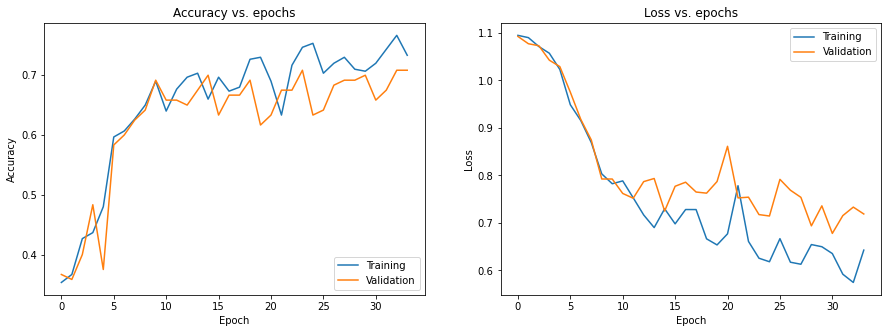

In [36]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_augmented.history['accuracy'])
    plt.plot(history_augmented.history['val_accuracy'])
except KeyError:
    plt.plot(history_augmented.history['acc'])
    plt.plot(history_augmented.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

We can see that overfitting has improved.

In [37]:
# Get model predictions for the first 3 batches of test data
num_batches = 3
seed = 25
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
predictions = lsun_new_model.predict_generator(test_generator, steps=num_batches)

Found 300 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 300 images belonging to 3 classes.
[19 45 20 40]


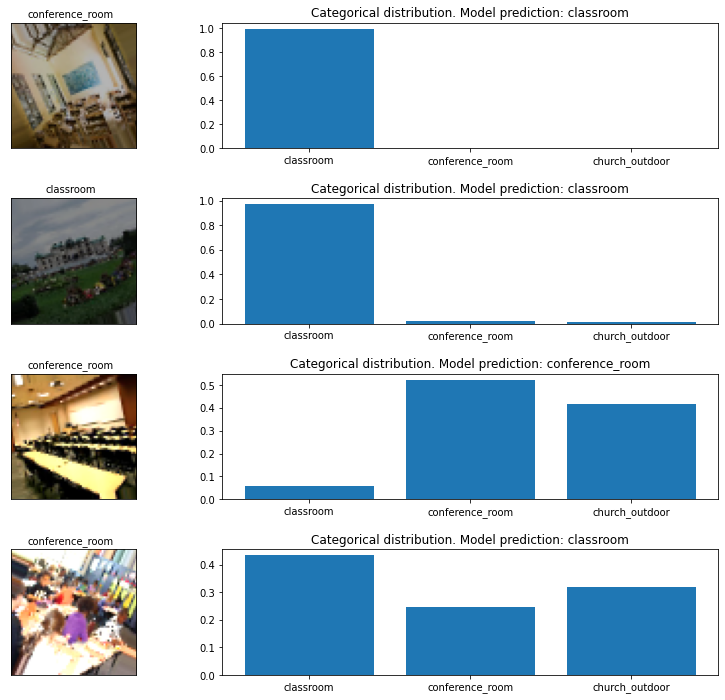

In [38]:
# View randomly selected images and model predictions

# Get images and ground truth labels
test_generator = get_generator(image_gen_aug, test_dir, seed=seed)
batches = []
for i in range(num_batches):
    batches.append(next(test_generator))
    
batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

# Randomly select images from the batch
inx = np.random.choice(predictions.shape[0], 4, replace=False)
print(inx)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for n, i in enumerate(inx):
    axes[n, 0].imshow(batch_images[i])
    axes[n, 0].get_xaxis().set_visible(False)
    axes[n, 0].get_yaxis().set_visible(False)
    axes[n, 0].text(30., -3.5, lsun_classes[np.where(batch_labels[i] == 1.)[0][0]], 
                    horizontalalignment='center')
    axes[n, 1].bar(np.arange(len(predictions[i])), predictions[i])
    axes[n, 1].set_xticks(np.arange(len(predictions[i])))
    axes[n, 1].set_xticklabels(lsun_classes)
    axes[n, 1].set_title(f"Categorical distribution. Model prediction: {lsun_classes[np.argmax(predictions[i])]}")
    
plt.show()

### Part 2: tf.data

#### The CIFAR-100 Dataset

In [97]:
# Load the data, along with the labels
(train_data, train_labels), (test_data, test_labels) = cifar100.load_data(label_mode='fine')
with open('data/cifar100/cifar100_labels.json', 'r') as j:
    cifar_labels = json.load(j)

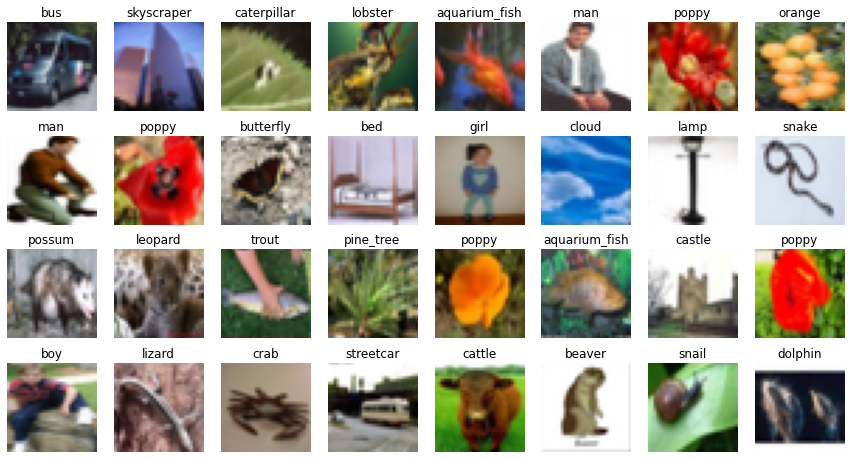

In [98]:
# Display a few images and labels
plt.figure(figsize=(15,8))
inx = np.random.choice(train_data.shape[0], 32, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(4, 8, n+1)
    plt.imshow(train_data[i])
    plt.title(cifar_labels[int(train_labels[i])])
    plt.axis('off')

In [105]:
# Create a tensorflow dataset object
def create_dataset(data, labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))

    return dataset

In [106]:
# Convert the training and test data and labels into datasets
train_dataset = create_dataset(train_data, train_labels)
test_dataset = create_dataset(test_data, test_labels)

In [107]:
# Check the element_spec
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))


In [109]:
# Only select those data points that belong to a specific class
def filter_classes(dataset, classes):

    def aux_filter(image, label):
      return tf.math.reduce_any(tf.equal(label, classes))
    
    return dataset.filter(aux_filter)


In [110]:
cifar_classes = [0, 29, 99] # Selected classes

# Filter the datasets
train_dataset = filter_classes(train_dataset, cifar_classes)
test_dataset = filter_classes(test_dataset, cifar_classes)

In [111]:
# Convert the label to a one-hot vector
def map_labels(dataset):
    
    def aux_map(image, label):
      if label == 0:
        return (image, tf.constant([1., 0., 0.]))
      elif label == 29:
        return (image, tf.constant([0., 1., 0.]))
      else:
        return (image, tf.constant([0., 0., 1.]))

    return dataset.map(aux_map)
    

In [112]:
# One-hot encode the training and test labels
train_dataset = map_labels(train_dataset)
test_dataset = map_labels(test_dataset)

In [113]:
# Scale the pixel values and convert to greyscale
def map_images(dataset):
    """
    This function should map over the dataset to process the image according to the 
    above specification. The function should then return the mapped Dataset object.
    """
    
    def aux_map(image, label):
      image = image / 255
      image = tf.reduce_mean(image, axis=2, keepdims=True)

      return image, label

    return dataset.map(aux_map)
    

In [114]:
# Apply your mapping function to the datasets
train_dataset_bw = map_images(train_dataset)
test_dataset_bw = map_images(test_dataset)

In [115]:
train_dataset.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None))

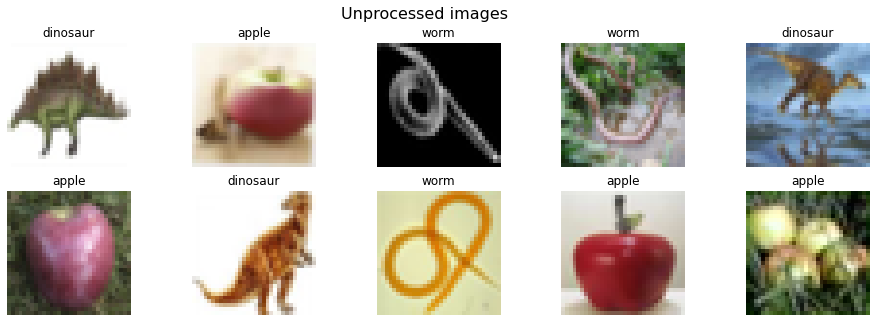

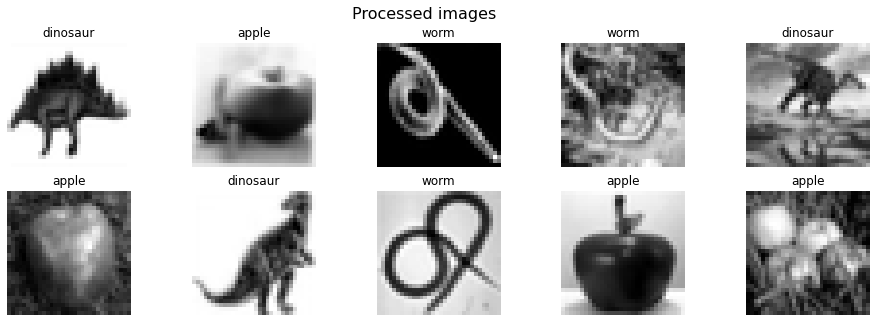

In [116]:
# View a selection of images before and after processing

plt.figure(figsize=(16,5))
plt.suptitle("Unprocessed images", fontsize=16)
for n, elem in enumerate(train_dataset.take(10)):
    images, labels = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels == 1.)[0][0]]])
    plt.imshow(np.squeeze(images), cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(16,5))
plt.suptitle("Processed images", fontsize=16)
for n, elem in enumerate(train_dataset_bw.take(10)):
    images_bw, labels_bw = elem
    ax = plt.subplot(2, 5, n+1)
    plt.title(cifar_labels[cifar_classes[np.where(labels_bw == 1.)[0][0]]])
    plt.imshow(np.squeeze(images_bw), cmap='gray')
    plt.axis('off')

We will now batch and shuffle the Dataset objects.

In [117]:
# Batch the training dataset and expand the final dimensinos

train_dataset_bw = train_dataset_bw.batch(10)
train_dataset_bw = train_dataset_bw.shuffle(100)

test_dataset_bw = test_dataset_bw.batch(10)
test_dataset_bw = test_dataset_bw.shuffle(100)

In [118]:
# Build and compile a new model with the original spec, using the new image size
cifar_model = get_model((32, 32, 1))

In [119]:
# Train the model for 15 epochs
history = cifar_model.fit(train_dataset_bw, validation_data=test_dataset_bw, epochs=15)

Epoch 1/15
150/150 [==============================] - 2s 8ms/step - loss: 1.0891 - accuracy: 0.3463 - val_loss: 0.9646 - val_accuracy: 0.5833
Epoch 2/15
150/150 [==============================] - 2s 7ms/step - loss: 0.9104 - accuracy: 0.5822 - val_loss: 0.7974 - val_accuracy: 0.6233
Epoch 3/15
150/150 [==============================] - 2s 8ms/step - loss: 0.7973 - accuracy: 0.6388 - val_loss: 0.7504 - val_accuracy: 0.6733
Epoch 4/15
150/150 [==============================] - 2s 7ms/step - loss: 0.7300 - accuracy: 0.6746 - val_loss: 0.6899 - val_accuracy: 0.7267
Epoch 5/15
150/150 [==============================] - 2s 7ms/step - loss: 0.6551 - accuracy: 0.7337 - val_loss: 0.6602 - val_accuracy: 0.7400
Epoch 6/15
150/150 [==============================] - 2s 8ms/step - loss: 0.6363 - accuracy: 0.7526 - val_loss: 0.6331 - val_accuracy: 0.7467
Epoch 7/15
150/150 [==============================] - 2s 7ms/step - loss: 0.6208 - accuracy: 0.7648 - val_loss: 0.5934 - val_accuracy: 0.7500
Epoch 

#### Plot the learning curves

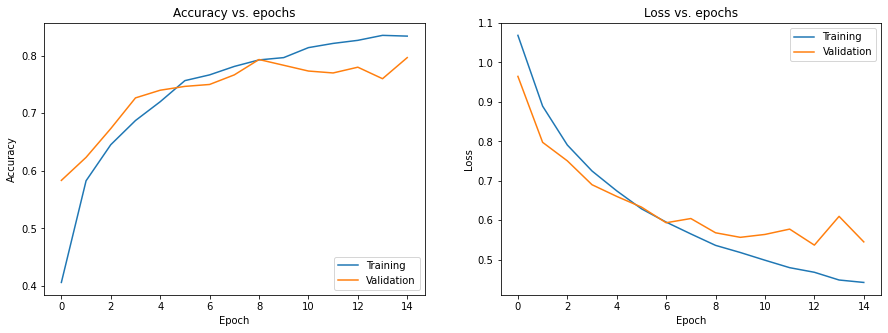

In [120]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [121]:
# Create an iterable from the batched test dataset
test_dataset = test_dataset.batch(10)
iter_test_dataset = iter(test_dataset)

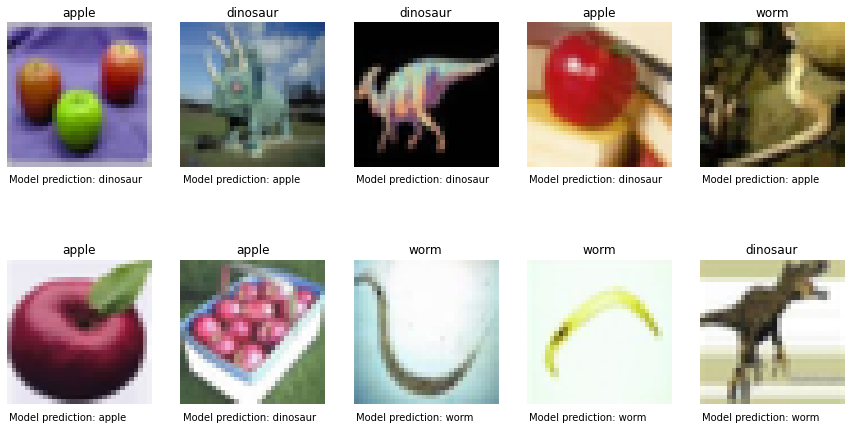

In [122]:
# Display model predictions for a sample of test images
plt.figure(figsize=(15,8))
inx = np.random.choice(test_data.shape[0], 18, replace=False)
images, labels = next(iter_test_dataset)
probs = cifar_model(tf.reduce_mean(tf.cast(images, tf.float32), axis=-1, keepdims=True) / 255.)
preds = np.argmax(probs, axis=1)
for n in range(10):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(images[n])
    plt.title(cifar_labels[cifar_classes[np.where(labels[n].numpy() == 1.0)[0][0]]])
    plt.text(0, 35, "Model prediction: {}".format(cifar_labels[cifar_classes[preds[n]]]))
    plt.axis('off')